In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

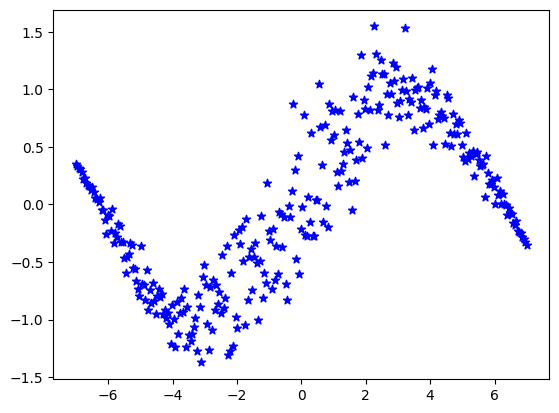

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

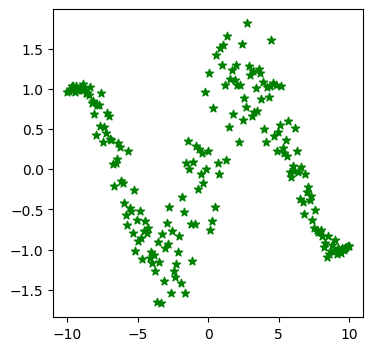

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [6]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
modelSamples = 50

In [8]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        self.hidden_size = 35

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.mu = nn.Linear(self.hidden_size, 1)
        self.var = nn.Linear(self.hidden_size, 1)

    def forward(self, x):

        h = torch.tanh(self.b1(x))
        h = torch.tanh(self.b2(h))

        input_noise = torch.normal(0, 1, size=(x.shape[0], self.hidden_size))

        t           = torch.tanh(self.t1(input_noise))
        t           = torch.tanh(self.t2(t))
        prod        = torch.multiply(t,h)

        mu = self.mu(prod)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(prod))
        return mu, var


def make_plot_dpo(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()



In [9]:
net = DeepONet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

DeepONet(
  (b1): Linear(in_features=1, out_features=35, bias=True)
  (b2): Linear(in_features=35, out_features=35, bias=True)
  (t1): Linear(in_features=35, out_features=35, bias=True)
  (t2): Linear(in_features=35, out_features=35, bias=True)
  (mu): Linear(in_features=35, out_features=1, bias=True)
  (var): Linear(in_features=35, out_features=1, bias=True)
)
Params: 3922


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
net.to(device);

In [13]:
def MLE_dopnn():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


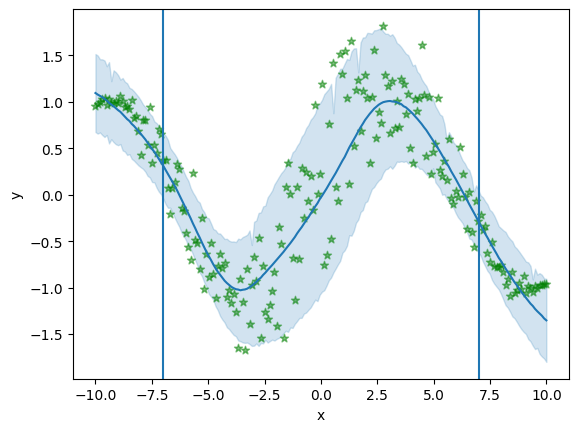

Epoch 149 | batch train loss: -1.0851881504058838 | test loss: 0.11354318261146545
Epoch 149 |batch train mse:0.08013062179088593| test mse:0.14119451149151876


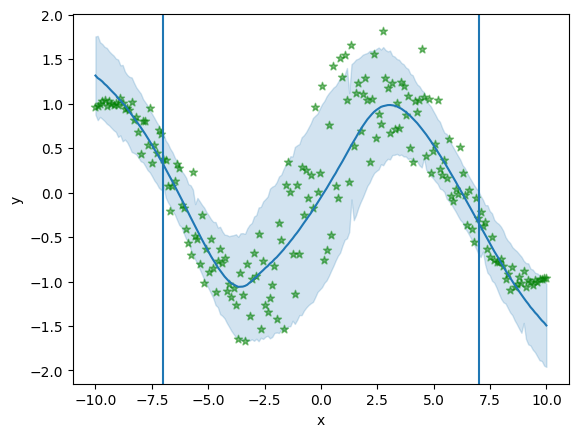

Epoch 149 | batch train loss: -1.1905359029769897 | test loss: 0.16192239408309644
Epoch 149 |batch train mse:0.053109586238861084| test mse:0.13877952098846436


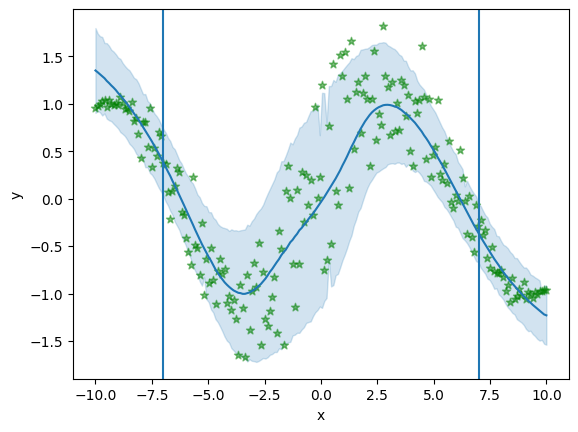

Epoch 149 | batch train loss: -1.1396960020065308 | test loss: 0.08404150146704453
Epoch 149 |batch train mse:0.04384584352374077| test mse:0.1410655897970383


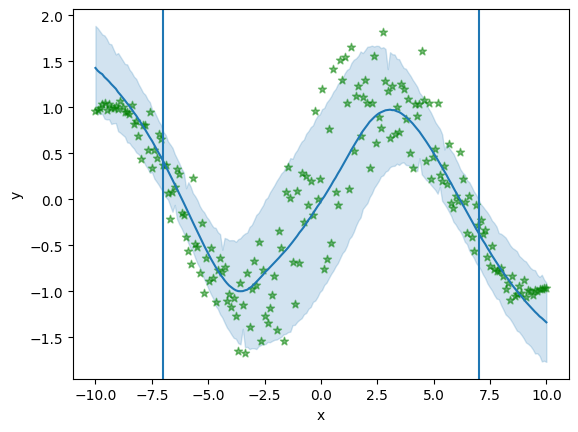

Epoch 149 | batch train loss: -1.4237165451049805 | test loss: 0.3670965817112189
Epoch 149 |batch train mse:0.04774034023284912| test mse:0.14615964631621653


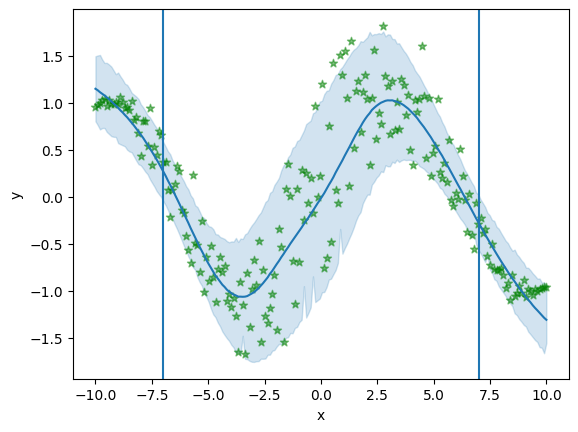

Epoch 149 | batch train loss: -1.341870903968811 | test loss: 0.0941976045186703
Epoch 149 |batch train mse:0.039350587874650955| test mse:0.14016685806787932


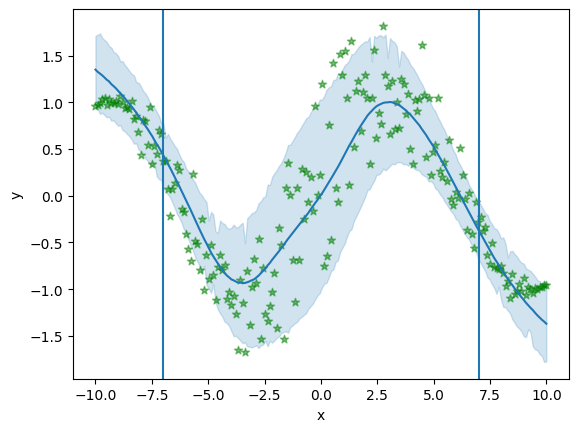

Epoch 149 | batch train loss: -1.1792374849319458 | test loss: 0.07770291543923892
Epoch 149 |batch train mse:0.059598322957754135| test mse:0.13613229990005493


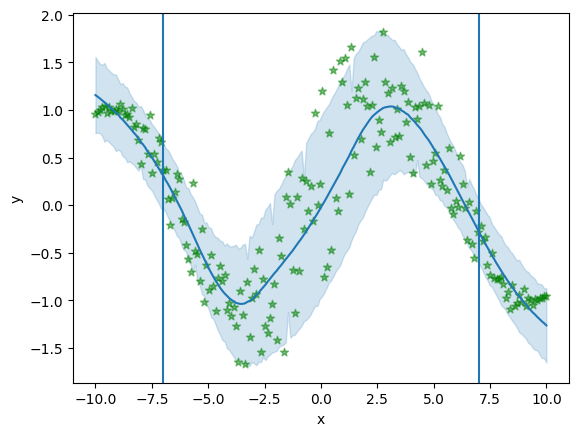

Epoch 149 | batch train loss: -1.3645166158676147 | test loss: 0.05492478981614113
Epoch 149 |batch train mse:0.055082157254219055| test mse:0.14095921728473443


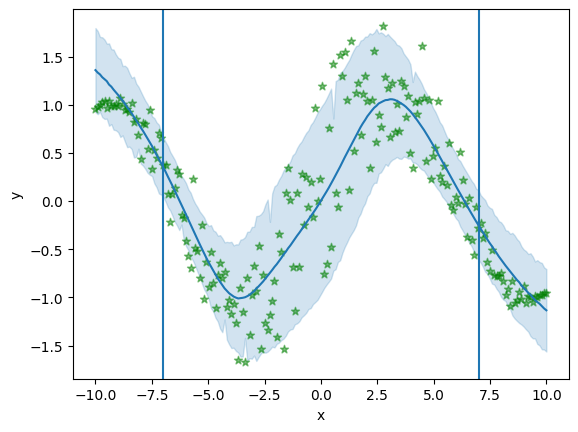

Epoch 149 | batch train loss: -1.2958273887634277 | test loss: 0.199095440025513
Epoch 149 |batch train mse:0.04355498030781746| test mse:0.14824461994262841


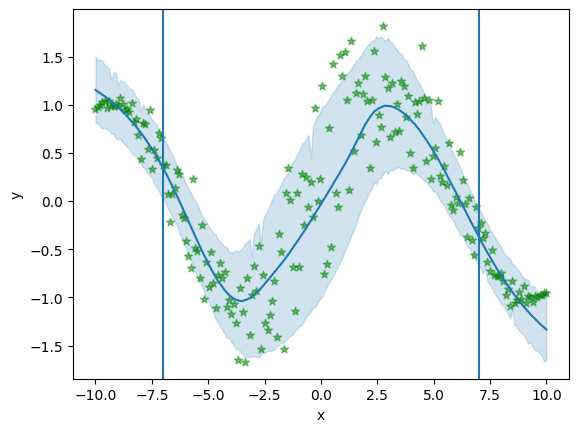

Epoch 149 | batch train loss: -1.1014834642410278 | test loss: 0.18677500463449037
Epoch 149 |batch train mse:0.0687226876616478| test mse:0.1426768205486811


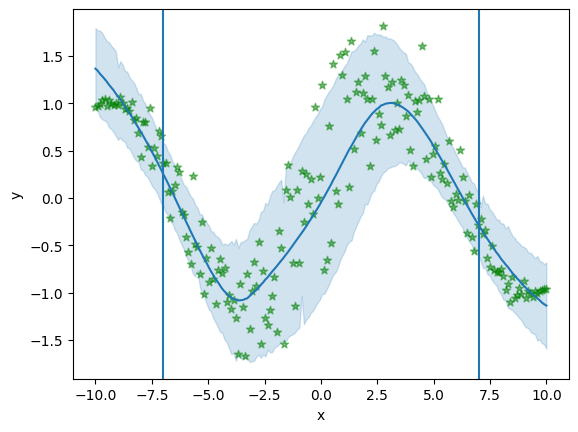

Epoch 149 | batch train loss: -0.7871249318122864 | test loss: 0.41678224962491256
Epoch 149 |batch train mse:0.06731296330690384| test mse:0.1525128294642155


In [14]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

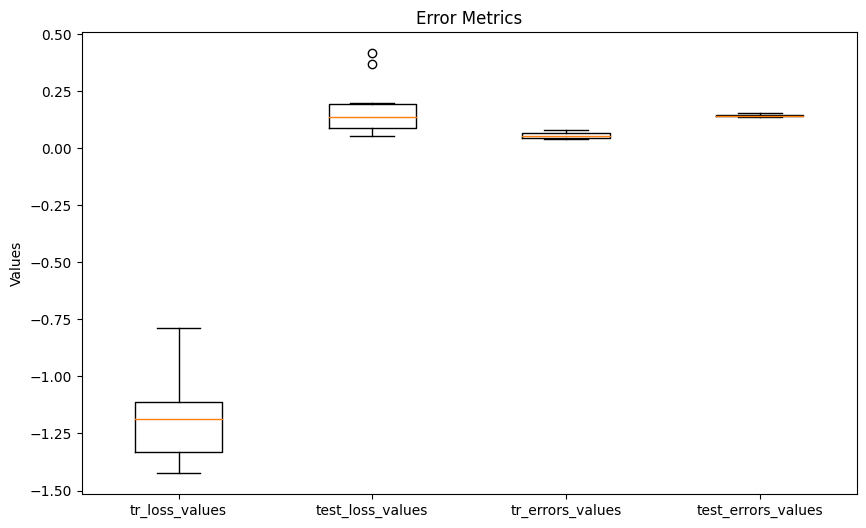

In [15]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metric for Deep Operator Neural Neworks')

# Show the plot
plt.show()


In [16]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.085188      0.113543                     0.080131   
2       -1.190536      0.161922                     0.053110   
3       -1.139696      0.084042                     0.043846   
4       -1.423717      0.367097                     0.047740   
5       -1.341871      0.094198                     0.039351   
6       -1.179237      0.077703                     0.059598   
7       -1.364517      0.054925                     0.055082   
8       -1.295827      0.199095                     0.043555   
9       -1.101483      0.186775                     0.068723   
10      -0.787125      0.416782                     0.067313   

    Mean Squared Testing Error  
1                     0.141195  
2                     0.138780  
3                     0.141066  
4                     0.146160  
5                     0.140167  
6                     0.136132  
7                     0.140959  
8                     0.148245 